In [35]:
#Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary

In [36]:
# Defining the category labels for MNIST
cates = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Normal transformation for test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Loading MNIST datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=test_transform
)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [37]:
# Defining the LeNet model with dropout
class LeNetWithDropout(nn.Module):
    def __init__(self):
        super(LeNetWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 28, kernel_size=5)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 90)
        self.fc3 = nn.Linear(90, 10)  # Output layer with 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 28 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initializing the model
LeNet_model = LeNetWithDropout()

In [38]:
# Displaying the model summary
summary(LeNet_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 28, 8, 8]           7,028
            Linear-3                  [-1, 120]          53,880
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 90]          10,890
           Dropout-6                   [-1, 90]               0
            Linear-7                   [-1, 10]             910
Total params: 72,968
Trainable params: 72,968
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.28
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


In [39]:
# Initializing the model, loss function, and optimizer
model = LeNetWithDropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Function to train and evaluate the model
def train_model(model, train_loader, test_loader, epochs=20):
    # Tracking training and validation accuracy
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()  # Setting model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculating loss and perform backpropagation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Tracking training accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Evaluating the model on the test set
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

        # Updating learning rate
        scheduler.step()

    # Confusion matrix for the final test
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cates, yticklabels=cates)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test Data')
    plt.show()

    # Plotting training and test accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Final accuracies
    final_train_accuracy = train_accuracies[-1]
    final_test_accuracy = test_accuracies[-1]

    print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
    print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Epoch 1, Train Accuracy: 77.93%, Test Accuracy: 96.50%
Epoch 2, Train Accuracy: 94.00%, Test Accuracy: 97.69%
Epoch 3, Train Accuracy: 95.45%, Test Accuracy: 98.44%
Epoch 4, Train Accuracy: 96.30%, Test Accuracy: 98.73%
Epoch 5, Train Accuracy: 96.81%, Test Accuracy: 98.65%
Epoch 6, Train Accuracy: 97.10%, Test Accuracy: 98.96%
Epoch 7, Train Accuracy: 97.40%, Test Accuracy: 99.06%
Epoch 8, Train Accuracy: 97.59%, Test Accuracy: 99.13%
Epoch 9, Train Accuracy: 97.77%, Test Accuracy: 99.15%
Epoch 10, Train Accuracy: 97.97%, Test Accuracy: 99.06%
Epoch 11, Train Accuracy: 98.16%, Test Accuracy: 99.17%
Epoch 12, Train Accuracy: 98.29%, Test Accuracy: 99.22%
Epoch 13, Train Accuracy: 98.29%, Test Accuracy: 99.24%
Epoch 14, Train Accuracy: 98.44%, Test Accuracy: 99.19%
Epoch 15, Train Accuracy: 98.44%, Test Accuracy: 99.26%
Epoch 16, Train Accuracy: 98.50%, Test Accuracy: 99.22%
Epoch 17, Train Accuracy: 98.61%, Test Accuracy: 99.24%
Epoch 18, Train Accuracy: 98.49%, Test Accuracy: 99.31%
E

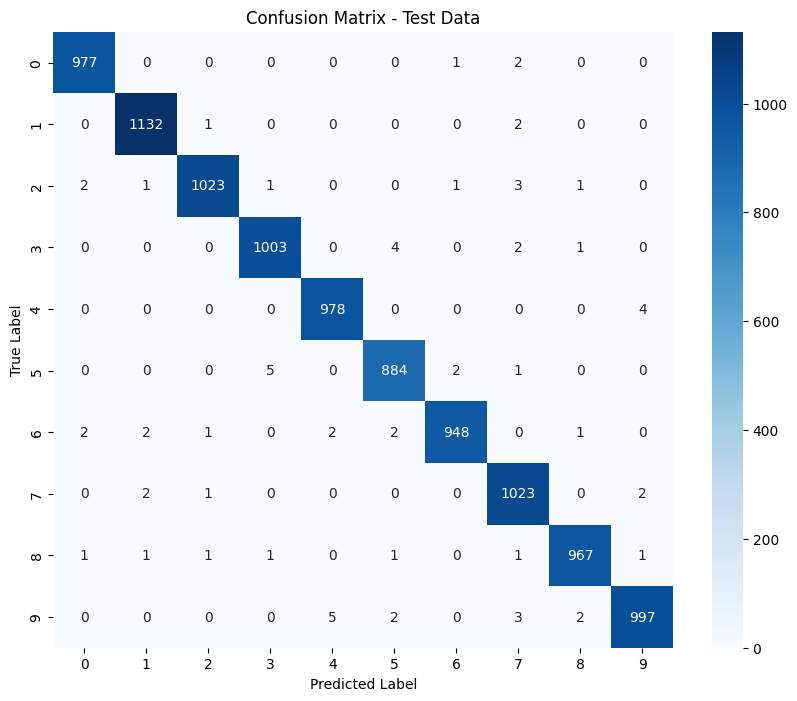

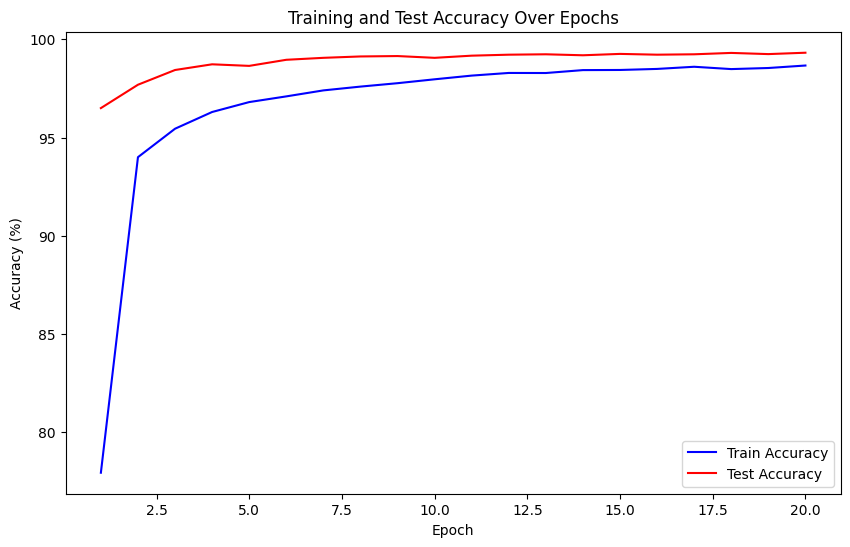

Final Train Accuracy: 98.67%
Final Test Accuracy: 99.32%


In [40]:
# Training the model with the training and test DataLoaders
train_model(model, train_loader, test_loader, epochs=20)

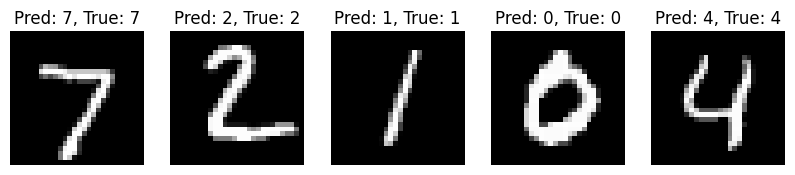

In [33]:
    # Visualizing output and predicted images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)  # Get the next batch
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Displaying the first 5 test samples with predictions and ground truth
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i][0], cmap='gray')  # Displaying the image in grayscale
        ax.set_title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        ax.axis('off')

    plt.show()